### Pandas를 활용하여 영화 평점 데이터 분석하기

- MovieLens 사용자들을 대상으로 수집한 영화 평점 데이터를 분석하기
- 데이터 출처 : https://grouplens.org/datasets/movielens/
- 데이터 내용 : 영화 평점, 장르, 개봉연도, 사용자 나이, 우편번호, 성별, 직업 등이 포함

- 실습 참조 : 
    - 파이썬 라이브러리를 활용한 데이터 분석
    - https://sandipanweb.wordpress.com/2017/12/16/data-science-with-python-exploratory-analysis-with-movie-ratings-and-fraud-detection-with-credit-card-transactions/

### NumPy

- 고성능 Array 처리 라이브러리

In [23]:
# numpy 설치
!pip install numpy

textract 1.6.1 has requirement chardet==2.3.0, but you'll have chardet 3.0.4 which is incompatible.
spyder-kernels 0.2.6 has requirement ipykernel>=4.8.2, but you'll have ipykernel 4.8.1 which is incompatible.
spyder-kernels 0.2.6 has requirement jupyter-client>=5.2.3, but you'll have jupyter-client 5.2.2 which is incompatible.
spyder-kernels 0.2.6 has requirement pyzmq>=17, but you'll have pyzmq 16.0.4 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 데이터 읽기

- 해당 데이터셋은 평점, 사용자 정보, 영화 정보 테이블로 구성되어있어서 각 파일을 따로 읽어와야 한다.

In [1]:
import pandas as pd

In [2]:
# 나이와 직업은 그룹을 가리키는 코드 번호이다
users = pd.read_table('./data/ml-1m/users.dat',\
                      sep='::', \
                      header=None, \
                      names=['user_id', 'gender', 'age', 'occupation', 'zip'])

users.head()

/Users/grace/workspace/keras/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [3]:
movies = pd.read_table('./data/ml-1m/movies.dat',\
                      sep='::',\
                      header=None,\
                      names=['movie_id', 'title', 'genres'])
movies.head()

/Users/grace/workspace/keras/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_table('./data/ml-1m/ratings.dat',\
                       sep='::',\
                       header=None,\
                       names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings.head()

/Users/grace/workspace/keras/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 영화 장르에 따른 평점의 변화 분석하기

### 데이터 전처리 1. 장르 데이터 확인 및 전처리 하기

In [5]:
# 하나의 영화는 하나의 장르가 아니라 여러 장르에 속할 수 있다
movies.genres.unique()[:10]

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance'], dtype=object)

In [6]:
# 각 영화 레코드를 장르에 따라 각각 추가하는 방식으로 전처리
# stack()는 데이터를 재구조화 하는 메소드
movies_ = pd.DataFrame(movies.genres.str.split('|').tolist(), \
                 index=[movies.movie_id, movies.title]).stack()
movies_.head()

movie_id  title              
1         Toy Story (1995)  0     Animation
                            1    Children's
                            2        Comedy
2         Jumanji (1995)    0     Adventure
                            1    Children's
dtype: object

unstacked

|index |col_1 | col_2|
|----|----|----|
|1 | 10 | 30 |
|2 | 20 | 40 |

stacked

|index|index| |
|---|-----|---|
|1 | col_1| 10|
|1 | col_1| 20|
|2 | col_2| 30|
|2 | col_2| 40|

In [7]:
movies_ = movies_.reset_index()[[0, 'movie_id', 'title']]
movies_.columns = ['genres', 'movie_id', 'title']
movies_.head()

,genres,movie_id,title
0,Animation,1,Toy Story (1995)
1,Children's,1,Toy Story (1995)
2,Comedy,1,Toy Story (1995)
3,Adventure,2,Jumanji (1995)
4,Children's,2,Jumanji (1995)


In [8]:
# 데이터가 제대로 반영되었는가 확인을 위해 비교 데이터 찾기
movies.loc[movies.movie_id==1]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy


#### 장르 갯수 확인하기

In [15]:
generes_cat = movies_.genres.unique()
generes_cat

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

### 데이터 전처리 2. timestamp -> year 데이터로 변환

In [10]:
import time
ratings.timestamp = ratings.timestamp.apply(lambda x: \
                                            time.strftime('%Y', time.localtime(x)))
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,2001
1,1,661,3,2001
2,1,914,3,2001
3,1,3408,4,2001
4,1,2355,5,2001


### 데이터 병합하기

- 모든 데이터를 하나의 테이블로 병합해서 처리하는 것이 더 편리하기 때문에 먼저 ratings와 users를 병합하고 이후에 movies와 병합한다.
- merge는 병합하는 두 테이블에서 중복되는 열의 이름을 키로 사용한다.

In [13]:
# ratings + users
data = pd.merge(ratings, users)
# + moview
data = pd.merge(data, movies_)

data.loc[data.movie_id==1]

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,genres,title
92452,1,1,5,2001,F,1,10,48067,Animation,Toy Story (1995)
92453,1,1,5,2001,F,1,10,48067,Children's,Toy Story (1995)
92454,1,1,5,2001,F,1,10,48067,Comedy,Toy Story (1995)
92455,6,1,4,2000,F,50,9,55117,Animation,Toy Story (1995)
92456,6,1,4,2000,F,50,9,55117,Children's,Toy Story (1995)
92457,6,1,4,2000,F,50,9,55117,Comedy,Toy Story (1995)
92458,8,1,4,2000,M,25,12,11413,Animation,Toy Story (1995)
92459,8,1,4,2000,M,25,12,11413,Children's,Toy Story (1995)
92460,8,1,4,2000,M,25,12,11413,Comedy,Toy Story (1995)
92461,9,1,5,2000,M,25,17,61614,Animation,Toy Story (1995)


#### 장르 별 평균 구하기

- 이미 timestamp값을 전처리해 연도 데이터로 변환한 상태이다.
- 연도, 장르에 따라서 평균 값을 구할 수 있다.

In [20]:
# groupby - 그룹 별로 분류 하는 메소드 (열, 행 둘다 가능)
# count, size, mean, sum 등 연사 메소드와 함께 사용하기에 유용하다.
data.groupby(['timestamp', 'genres']).size()[:20]

timestamp  genres     
2000       Action         238047
           Adventure      124026
           Animation       38904
           Children's      65074
           Comedy         321329
           Crime           72589
           Documentary      6940
           Drama          318468
           Fantasy         33550
           Film-Noir       16897
           Horror          69890
           Musical         37390
           Mystery         36662
           Romance        133714
           Sci-Fi         146012
           Thriller       172808
           War             63423
           Western         19027
2001       Action          14176
           Adventure        7134
dtype: int64

In [30]:
# 위에는 groupby 분류에 인덱스로 timestamp, genres가 지정되었다.
# 하지만, 인덱스로 지정하지 않을 수 있다

# agg를 통해 여러 그룹 연산을 진행할 수 있다.
data.groupby(['timestamp', 'genres'], \
             as_index=False).agg({'rating':['mean', 'min', 'max']}).head(10)

timestamp       genres    rating        
                              mean min max
0      2000       Action  3.501582   1   5
1      2000    Adventure  3.487374   1   5
2      2000    Animation  3.699388   1   5
3      2000   Children's  3.430909   1   5
4      2000       Comedy  3.532943   1   5
5      2000        Crime  3.716885   1   5
6      2000  Documentary  3.941210   1   5
7      2000        Drama  3.774266   1   5
8      2000      Fantasy  3.455499   1   5
9      2000    Film-Noir  4.079837   1   5

In [38]:
# 원하는 함수는 평균만 구하는 것
mean_ratings = data.groupby(['timestamp', 'genres'], \
                            as_index=False).agg({'rating':'mean'})
mean_ratings.head(10)

,timestamp,genres,rating
0,2000,Action,3.501582
1,2000,Adventure,3.487374
2,2000,Animation,3.699388
3,2000,Children's,3.430909
4,2000,Comedy,3.532943
5,2000,Crime,3.716885
6,2000,Documentary,3.941210
7,2000,Drama,3.774266
8,2000,Fantasy,3.455499
9,2000,Film-Noir,4.079837


In [33]:
# column을 선택하고 aggregate를 활용해, 원하는 함수를 지정할 수도 있다.
# 다음의 경우, np.mean을 활용해 설정
import numpy as np

data.groupby(['timestamp', 'genres'], \
             as_index=False)['rating'].aggregate(np.mean).head(10)

,timestamp,genres,rating
0,2000,Action,3.501582
1,2000,Adventure,3.487374
2,2000,Animation,3.699388
3,2000,Children's,3.430909
4,2000,Comedy,3.532943
5,2000,Crime,3.716885
6,2000,Documentary,3.941210
7,2000,Drama,3.774266
8,2000,Fantasy,3.455499
9,2000,Film-Noir,4.079837


In [39]:
# 컬럼명을 재정리
mean_ratings.rename(columns={'timestamp':'year'}, inplace=True)
mean_ratings.head()

,year,genres,rating
0,2000,Action,3.501582
1,2000,Adventure,3.487374
2,2000,Animation,3.699388
3,2000,Children's,3.430909
4,2000,Comedy,3.532943


In [61]:
mean_ratings.shape

(72, 3)

### 평균 추이 그래프 그리기

In [41]:
import matplotlib.pyplot as plt

[Text(0,0,'2000'), Text(0,0,'2001'), Text(0,0,'2002'), Text(0,0,'2003')]

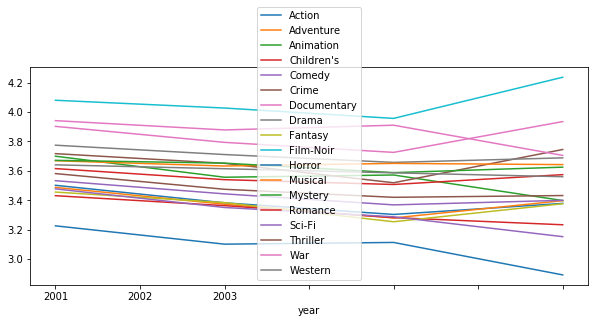

In [62]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

for key, grp in mean_ratings.groupby(mean_ratings.genres):
    ax = grp.plot(ax=ax, kind='line', x='year', y='rating', label=key)
ax.set_xticklabels([2000, 2001, 2002, 2003])